<a href="https://colab.research.google.com/github/arndmghsh/ImageSegmentation-StructuredSVM/blob/master/10618_HW3_4_structSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade ortools

     |████████████████████████████████| 27.7MB 85kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !unzip -uq "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages.zip" -d "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages"

In [0]:
# !unzip -uq "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledLabels.zip" -d "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3"

In [0]:
import os

import matplotlib.pyplot as plt

from PIL import Image
import torchvision.transforms.functional as TF

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ortools.linear_solver import pywraplp

In [0]:
NUM_CLASSES = 2
NUM_FEATURES = 100

In [0]:
class VOCDataset(Dataset):
    """Class to store VOC semantic segmentation dataset"""

    def __init__(self, image_dir, label_dir, file_list):

        self.image_dir = image_dir
        self.label_dir = label_dir
        reader = open(file_list, "r")
        self.files = []
        for file in reader:
            self.files.append(file.strip())

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        # 0 stands for background, 1 for foreground
        labels = np.load(os.path.join(self.label_dir, fname+".npy"))
        labels[labels > 0.0] = 1.0
        image = Image.open(os.path.join(self.image_dir, fname+".jpg"), "r")
        sample = (TF.to_tensor(image), torch.LongTensor(labels))

        return sample

In [0]:
class AlexNet(nn.Module):
    """Class defining AlexNet layers used for the convolutional network"""

    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=2, padding=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        return x

In [0]:
class FCNHead(nn.Sequential):
    """Class defining FCN (fully convolutional network) layers"""

    def __init__(self, in_channels, channels):
        inter_channels = in_channels // 4
        layers = [
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(inter_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv2d(inter_channels, channels, 1)
        ]

        super(FCNHead, self).__init__(*layers)

In [0]:
class SimpleSegmentationModel(nn.Module):
    """
    Class defining end-to-end semantic segmentation model.
    It combines AlexNet and FCN layers with interpolation for deconvolution.
    This model is pretrained using cross-entropy loss.
    After pre-training, use the get_repr() function to construct 32x32x100 feature tensors for each image
    """

    def __init__(self, n_feat, n_classes):
        super(SimpleSegmentationModel, self).__init__()
        self.n_feat = n_feat
        self.backbone = AlexNet()
        self.classifier = FCNHead(256, n_feat)
        self.linear = nn.Linear(n_feat, n_classes)

    def forward(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(-1, self.n_feat)
        x = self.linear(x)

        return x

    def get_repr(self, x):
        input_shape = x.shape[-2:]
        features = self.backbone(x)
        x = self.classifier(features)
        x = F.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        x = x.permute(0, 2, 3, 1)
        return x

In [0]:
class LinearSVM(nn.Module):
    def __init__(self, n_feat, n_classes):
        super(LinearSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        # TODO: Define weights for linear SVM
        # self.w = torch.autograd.Variable(torch.rand(n_feat), requires_grad=True)
        # self.b = torch.autograd.Variable(torch.rand(1), requires_grad=True)
        self.linear = nn.Linear(n_feat, n_classes)
    
    def forward(self, x):
        # TODO: Define forward function for linear SVM
        # x: 1 x 32 x 32 x 100
        x = x.contiguous().view(-1, self.n_feat)
        # x: 1024 x 100
        y_hat = self.linear(x)      # returns 1024 x 2
        return y_hat

In [0]:
class StructSVM(nn.Module):
    def __init__(self, n_feat, n_classes, w, h):
        super(StructSVM, self).__init__()
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.w = w
        self.h = h
        # TODO: Define weights for structured SVM
        self.lin100 = nn.Linear(n_feat, n_classes)
        self.lin200 = nn.Linear(2*n_feat, n_classes)

    def forward(self, image):
        # TODO: Define forward function for structured SVM
        # image: 1 x 32 x 32 x 100
        image = image.squeeze() # torch.Size([32, 32, 100])
        unary = self.lin100(image)  # torch.Size([32, 32, 2])
        # [i,j] and [i,j+1]
        edge1 = torch.zeros(self.w, self.h-1, 2)
        for i in range(self.w):
          for j in range(self.h-1):
            # image[i,j].shape, image[i,j+1].shape =  torch.Size([100])
            concat = torch.cat((image[i,j], image[i,j+1]), dim=0)
            # concat shape = torch.Size([200])
            edge1[i,j] = self.lin200(concat)
        # [i,j] and [i+1,j]
        edge2 = torch.zeros(self.w-1, self.h, 2)
        for i in range(self.w-1):
          for j in range(self.h):
            concat = torch.cat((image[i,j], image[i+1,j]), dim=0)
            edge2[i,j] = self.lin200(concat)
        # Unary, edge1, edge2 = torch.Size([32, 32, 2]) torch.Size([32, 31, 2]) torch.Size([31, 32, 2])
        return unary, edge1, edge2

In [0]:
def train_cnn(model, train_batches, test_batches, num_epochs):
    """
    This function runs a training loop for the FCN semantic segmentation model
    """
    criterion = nn.CrossEntropyLoss(weight=torch.Tensor([1, 4]))
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            # Images: torch.Size([1, 3, 32, 32]), Labels = torch.Size([1, 32, 32])
            output = model(images)
            # output: 32*32 x 2 = torch.Size([1024, 2])
            labels = labels.contiguous().view(-1, 1).squeeze()
            # labels: torch.Size([1024])
            loss = criterion(output, labels)  # inputs: torch.Size([1024, 2]) and torch.Size([1024])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            print("Epoch: {}, itr: {}".format(epoch, i))
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_cnn(model, train_batches)

In [0]:
def test_cnn(model, test_batches):
    """
        This function evaluates the FCN semantic segmentation model on the test set
    """
    correct = 0.0
    total = 0.0
    class_gold = [0.0] * NUM_CLASSES
    class_pred = [0.0] * NUM_CLASSES
    class_correct = [0.0] * NUM_CLASSES
    for i, batch in enumerate(test_batches):
        images, labels = batch
        output = model(images)
        _, output = torch.max(output, axis=1)
        visualize_grayscale_image(output.view(32, 32).detach().numpy(), i)
        output = output.squeeze().detach().numpy()
        labels = labels.contiguous().view(-1, 1).squeeze().numpy()
        cur_class_pred = np.unique(output, return_counts=True)
        for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
            class_pred[key] += val
        cur_class_gold = np.unique(labels, return_counts=True)
        for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
            class_gold[key] += val
        cur_correct = (output == labels).tolist()
        for j, val in enumerate(cur_correct):
            if val:
                class_correct[labels[j]] += 1
        correct += np.sum(cur_correct)
        total += len(labels)
    class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
    mean_iou = sum(class_iou) / len(class_correct)
    print("Mean IOU: {}".format(mean_iou))
    print("Pixel Accuracy: {}\n".format(correct / total))

In [0]:
def train_linear_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the linear SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    criterion = nn.MultiMarginLoss(weight=torch.Tensor([1, 4]))  # Class weights to handle class imbalance
    optimizer = optim.Adam(svm_model.parameters(), lr=0.0001)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for i, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            # Images: torch.Size([1, 3, 32, 32]), Labels = torch.Size([1, 32, 32])
            fcn_output = cnn_model.get_repr(images)  # returns 1 x 32 x 32 x 100
            output = svm_model(fcn_output)       # torch.Size([1024, 2])
            labels = labels.contiguous().view(-1, 1).squeeze()   # labels: torch.Size([1024])
            loss = criterion(output, labels)    # inputs = torch.Size([1024, 2]) and torch.Size([1024])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            # print("Epoch: {}, itr: {}".format(epoch, i))
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        test_linear_svm(cnn_model, svm_model, train_batches)
    return

In [0]:
def test_linear_svm(cnn_model, svm_model, test_batches):
    # TODO: Write a testing function for the linear SVM
    correct = 0.0
    total = 0.0
    class_gold = [0.0] * NUM_CLASSES
    class_pred = [0.0] * NUM_CLASSES
    class_correct = [0.0] * NUM_CLASSES
    for i, batch in enumerate(test_batches):
        images, labels = batch
        fcn_output = cnn_model.get_repr(images)  # returns 1 x 32 x 32 x 100
        output = svm_model(fcn_output)       # torch.Size([1024, 2])
        _, output = torch.max(output, axis=1)
        visualize_grayscale_image(output.view(32, 32).detach().numpy(), i)
        output = output.squeeze().detach().numpy()
        labels = labels.contiguous().view(-1, 1).squeeze().numpy()

        cur_class_pred = np.unique(output, return_counts=True)
        for key, val in zip(cur_class_pred[0], cur_class_pred[1]):
            class_pred[key] += val
        cur_class_gold = np.unique(labels, return_counts=True)
        for key, val in zip(cur_class_gold[0], cur_class_gold[1]):
            class_gold[key] += val
        cur_correct = (output == labels).tolist()
        for j, val in enumerate(cur_correct):
            if val:
                class_correct[labels[j]] += 1
        correct += np.sum(cur_correct)
        total += len(labels)
    class_iou = [x/(y+z-x) for x, y, z in zip(class_correct, class_gold, class_pred)]
    mean_iou = sum(class_iou) / len(class_correct)
    print("Mean IOU: {}".format(mean_iou))
    print("Pixel Accuracy: {}\n".format(correct / total))

    return

In [0]:
def loss_aug_map_inference(solver, label_ind, unary, edge1, edge2, x_assign, y1_assign, y2_assign):
    # Define objective
    obj = 0.0
    for i in range(32):
      for j in range(32):
        for c in range(2):
          obj += unary[i,j,c]*x_assign[i,j,c]
          obj += (1/(32*32*2))*(label_ind[i,j,c]*(1-x_assign[i,j,c]) 
                                        + (1-label_ind[i,j,c])*x_assign[i,j,c])
    for i in range(32):
      for j in range(31):
        for c in range(2):
          obj += edge1[i,j,c]*y1_assign[i,j,c]
    for i in range(31):
      for j in range(32):
        for c in range(2):
          obj += edge2[i,j,c]*y2_assign[i,j,c]
    
    solver.Maximize(obj)
    
    # Solve ILP again
    result = solver.Solve()
    assert result == pywraplp.Solver.OPTIMAL
    assert solver.VerifySolution(1e-7, True)

    # Gather the optimal assignment
    final_x_assign = torch.zeros((32, 32, 2))
    final_y1_assign = torch.zeros((32, 31, 2))
    final_y2_assign = torch.zeros((31, 32, 2))
    for i in range(32):
      for j in range(32):
        for c in range(2):
          final_x_assign[i, j, c] = x_assign[i,j,c].solution_value()
    for i in range(32):
      for j in range(31):
        for c in range(2):
          final_y1_assign[i, j, c] = y1_assign[i,j,c].solution_value()
    for i in range(31):
      for j in range(32):
        for c in range(2):
          final_y2_assign[i, j, c] = y2_assign[i,j,c].solution_value()

    return final_x_assign, final_y1_assign, final_y2_assign

In [0]:
# TODO: Write a function to compute the structured hinge loss
# using the max-scoring output from the ILP and the gold output
def compute_struct_svm_loss(unary, edge1, edge2, label_ind, edge1_ind, edge2_ind,
                                           final_x_assign, final_y1_assign, final_y2_assign):
  # Score term (Predicted)
  score_pred = 0.0
  score_pred += torch.sum(unary*final_x_assign)
  score_pred += torch.sum(edge1*final_y1_assign)
  score_pred += torch.sum(edge2*final_y2_assign)
  # Hamming loss term
  hloss = 0.0
  for i in range(32):
      for j in range(32):
        for c in range(2):
          if(final_x_assign[i,j,c] != label_ind[i,j,c]):
            hloss += 1
  hloss = hloss/(32*32*2)
  # Score term (Gold)
  score_gold = 0.0
  label_ind = torch.tensor(label_ind)
  score_gold += torch.sum(unary*label_ind)
  score_gold += torch.sum(edge1*edge1_ind)
  score_gold += torch.sum(edge2*edge2_ind)
  # Total loss
  total_loss = score_pred + hloss - score_gold
  # return torch.max(torch.Tensor([0.0, total_loss]))
  return  F.relu(total_loss)

In [0]:
def train_struct_svm(cnn_model, svm_model, train_batches, test_batches, num_epochs):
    # TODO: Write a training loop for the structured SVM
    # Keep in mind that the CNN model is needed to compute features, but it should not be finetuned
    # Define ILP Solver
    solver = pywraplp.Solver('LinearExample', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
    # Define assignment variables
    x_assign = {}
    for i in range(32):
      for j in range(32):
        for c in range(2):
          x_assign[i, j, c] = solver.NumVar(0.0, 1.0, 'x[%d,%d, %d]' % (i, j, c))
    # Define assignment variables
    y1_assign = {}
    for i in range(32):
      for j in range(31):
        for c in range(2):
          y1_assign[i, j, c] = solver.NumVar(0.0, 1.0, 'y1[%d,%d, %d]' % (i, j, c))
    # Define assignment variables
    y2_assign = {}
    for i in range(31):
      for j in range(32):
        for c in range(2):
          y2_assign[i, j, c] = solver.NumVar(0.0, 1.0, 'y2[%d,%d, %d]' % (i, j, c))

    # Add constraints
    for i in range(32):
      for j in range(32):
        solver.Add(solver.Sum([x_assign[i,j,c] for c in range(2)])==1)
    # Add constraints
    for i in range(32):
      for j in range(31):
        for c in range(2):
          solver.Add(y1_assign[i,j,c]<=x_assign[i,j,c])
          solver.Add(y1_assign[i,j,c]<=x_assign[i,j+1,c])
    # Add constraints
    for i in range(31):
      for j in range(32):
        for c in range(2):
          solver.Add(y2_assign[i,j,c]<=x_assign[i,j,c])
          solver.Add(y2_assign[i,j,c]<=x_assign[i+1,j,c])

    optimizer = optim.Adam(svm_model.parameters(), lr=0.0001)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for itr, batch in enumerate(train_batches):
            optimizer.zero_grad()
            images, labels = batch
            # Images: torch.Size([1, 3, 32, 32]), Labels = torch.Size([1, 32, 32])
            fcn_output = cnn_model.get_repr(images)  # returns 1 x 32 x 32 x 100
            unary, edge1, edge2 = svm_model(fcn_output)
            # Unary, edge1, edge2 = torch.Size([32, 32, 2]) torch.Size([32, 31, 2]) torch.Size([31, 32, 2])          
            # unary = unary.squeeze()
            # edge1 = edge1.squeeze()
            # edge2 = edge2.squeeze()
            labels = labels.squeeze()   # Labels = torch.Size([32, 32])

            # Perform loss-augmented MAP inference via ILP
            unary_np = unary.detach().numpy()
            edge1_np = edge1.detach().numpy()
            edge2_np = edge2.detach().numpy()
            # Construct the Gold X indicators
            label_ind = np.zeros((32,32,2))
            for i in range(32):
              for j in range(32):
                label_ind[i,j,labels[i,j]] = 1
            # Loss-augmented MAP inference
            final_x_assign, final_y1_assign, final_y2_assign = loss_aug_map_inference(solver, label_ind, unary_np, 
                                                                        edge1_np, edge2_np, x_assign, y1_assign, y2_assign)

            # Construct the Gold Y indicators
            edge1_ind = torch.zeros((32,31,2))
            edge2_ind = torch.zeros((31,32,2))
            for i in range(32):
              for j in range(31):
                if labels[i,j]==1 and labels[i,j+1]==1:
                  edge1_ind[i,j,1] = 1
                if labels[i,j]==0 and labels[i,j+1]==0:
                  edge1_ind[i,j,0] = 1
            for i in range(31):
              for j in range(32):
                if labels[i,j]==1 and labels[i+1,j]==1:
                  edge2_ind[i,j,1] = 1
                if labels[i,j]==0 and labels[i+1,j]==0:
                  edge2_ind[i,j,0] = 1
            # Structured Hinge Loss
            loss = compute_struct_svm_loss(unary, edge1, edge2, label_ind, edge1_ind, edge2_ind,
                                           final_x_assign, final_y1_assign, final_y2_assign)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            print("Epoch: {}, itr: {}".format(epoch, itr))
            # if itr==20:
            #   break
        # print("Training loss after epoch {}: {}".format(epoch, total_loss/itr))
        print("Training loss after epoch {}: {}".format(epoch, total_loss/len(train_batches)))
        # test_linear_svm(cnn_model, svm_model, train_batches)
    return

In [0]:
def test_struct_svm(cnn_model, svm_model, test_batches):
    # TODO: Write a testing function for the structured SVM
    return

In [0]:
def visualize_grayscale_image(image, file=None):
    plt.imshow(image, cmap="gray")
    # Uncomment this to visualize image
    # plt.show()
    # Uncomment this to save image
    # plt.savefig(str(file)+".png")

Epoch: 0, itr: 0
Epoch: 0, itr: 1
Epoch: 0, itr: 2
Epoch: 0, itr: 3
Epoch: 0, itr: 4
Epoch: 0, itr: 5
Epoch: 0, itr: 6
Epoch: 0, itr: 7
Epoch: 0, itr: 8
Epoch: 0, itr: 9
Epoch: 0, itr: 10
Epoch: 0, itr: 11
Epoch: 0, itr: 12
Epoch: 0, itr: 13
Epoch: 0, itr: 14
Epoch: 0, itr: 15
Epoch: 0, itr: 16
Epoch: 0, itr: 17
Epoch: 0, itr: 18
Epoch: 0, itr: 19
Epoch: 0, itr: 20
Epoch: 0, itr: 21
Epoch: 0, itr: 22
Epoch: 0, itr: 23
Epoch: 0, itr: 24
Epoch: 0, itr: 25
Epoch: 0, itr: 26
Epoch: 0, itr: 27
Epoch: 0, itr: 28
Epoch: 0, itr: 29
Epoch: 0, itr: 30
Epoch: 0, itr: 31
Epoch: 0, itr: 32
Epoch: 0, itr: 33
Epoch: 0, itr: 34
Epoch: 0, itr: 35
Epoch: 0, itr: 36
Epoch: 0, itr: 37
Epoch: 0, itr: 38
Epoch: 0, itr: 39
Epoch: 0, itr: 40
Epoch: 0, itr: 41
Epoch: 0, itr: 42
Epoch: 0, itr: 43
Epoch: 0, itr: 44
Epoch: 0, itr: 45
Epoch: 0, itr: 46
Epoch: 0, itr: 47
Epoch: 0, itr: 48
Epoch: 0, itr: 49
Epoch: 0, itr: 50
Epoch: 0, itr: 51
Epoch: 0, itr: 52
Epoch: 0, itr: 53
Epoch: 0, itr: 54
Epoch: 0, itr: 55
Ep

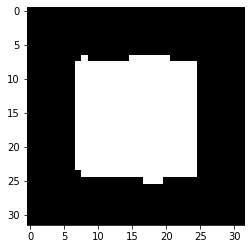

In [0]:
if __name__ == "__main__":

    seed = 42
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Uncomment following lines after providing appropriate paths
    path_to_image_folder = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledImages"
    path_to_label_folder = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/DownsampledLabels"
    file_with_train_ids = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/train.txt"
    file_with_test_ids = "/content/drive/My Drive/00_CMU/03_ML_structured_data/HW3/test.txt"
    
    train_dataset = VOCDataset(path_to_image_folder, path_to_label_folder, file_with_train_ids)
    test_dataset = VOCDataset(path_to_image_folder, path_to_label_folder, file_with_test_ids)

    train_batches = DataLoader(train_dataset, batch_size=1, shuffle=True)
    test_batches = DataLoader(test_dataset, batch_size=1, shuffle=True)

    cnn = SimpleSegmentationModel(NUM_FEATURES, NUM_CLASSES)
    train_cnn(cnn, train_batches, test_batches, 2)
    test_cnn(cnn, test_batches)

Training loss after epoch 0: 0.6509752579640933
Mean IOU: 0.3989965572194325
Pixel Accuracy: 0.6033462982832618

Training loss after epoch 1: 0.6299050095894818
Mean IOU: 0.39956837888217933
Pixel Accuracy: 0.6042972941255365

Training loss after epoch 2: 0.6291903404207189
Mean IOU: 0.4011234037881908
Pixel Accuracy: 0.6067554653969958

Mean IOU: 0.38932917204176226
Pixel Accuracy: 0.596430102915952



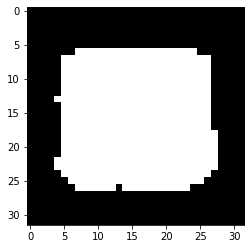

In [0]:
# TODO: Instantiate a linear SVM and call train/ test functions
linear_svm = LinearSVM(n_feat = NUM_FEATURES, n_classes = NUM_CLASSES)
train_linear_svm(cnn, linear_svm, train_batches, test_batches, num_epochs = 3)
test_linear_svm(cnn, linear_svm, test_batches)

In [0]:
# TODO: Instantiate a structured SVM and call train/ test functions
struct_svm = StructSVM(n_feat = NUM_FEATURES, n_classes = NUM_CLASSES, w = 32, h = 32)
train_struct_svm(cnn, struct_svm, train_batches, test_batches, num_epochs = 3)
# test_struct_svm(cnn, struct_svm, test_batches)

Epoch: 0, itr: 0
Epoch: 0, itr: 1
Epoch: 0, itr: 2
Epoch: 0, itr: 3
Epoch: 0, itr: 4
Epoch: 0, itr: 5
Epoch: 0, itr: 6
Epoch: 0, itr: 7
Epoch: 0, itr: 8
Epoch: 0, itr: 9
Epoch: 0, itr: 10
Epoch: 0, itr: 11
Epoch: 0, itr: 12
Epoch: 0, itr: 13
Epoch: 0, itr: 14
Epoch: 0, itr: 15
Epoch: 0, itr: 16
Epoch: 0, itr: 17
Epoch: 0, itr: 18
Epoch: 0, itr: 19
Epoch: 0, itr: 20
Epoch: 0, itr: 21
Epoch: 0, itr: 22
Epoch: 0, itr: 23
Epoch: 0, itr: 24
Epoch: 0, itr: 25
Epoch: 0, itr: 26
Epoch: 0, itr: 27
Epoch: 0, itr: 28
Epoch: 0, itr: 29
Epoch: 0, itr: 30
Epoch: 0, itr: 31
Epoch: 0, itr: 32
Epoch: 0, itr: 33
Epoch: 0, itr: 34
Epoch: 0, itr: 35
Epoch: 0, itr: 36
Epoch: 0, itr: 37
Epoch: 0, itr: 38
Epoch: 0, itr: 39
Epoch: 0, itr: 40
Epoch: 0, itr: 41
Epoch: 0, itr: 42
Epoch: 0, itr: 43
Epoch: 0, itr: 44
Epoch: 0, itr: 45
Epoch: 0, itr: 46
Epoch: 0, itr: 47
Epoch: 0, itr: 48
Epoch: 0, itr: 49
Epoch: 0, itr: 50
Epoch: 0, itr: 51
Epoch: 0, itr: 52
Epoch: 0, itr: 53
Epoch: 0, itr: 54
Epoch: 0, itr: 55
Ep